In [1]:
from db import attach_duckdb, duckdb_to_df, load_sql

attach_duckdb()
query = load_sql("xgb-cohort.sql")

df = duckdb_to_df(query)
df.head()


DuckDB attached to remote PostgreSQL successfully.


,subject_id,hadm_id,stay_id,label,age,is_male,heart_rate_mean,mbp_mean,shock_index,resp_rate_mean,...,sodium_min,lactate_max,bun_max,creatinine_max,aniongap_max,charlson_index,apsiii,oasis,sapsii,sofa_max_24h
0,13288288,29836602,30245775,1,59.063378,1,182.000000,NaN,NaN,21.750000,...,NaN,NaN,NaN,NaN,NaN,8,52,41,55,4
1,12104118,29162170,30247984,0,77.686607,0,84.621622,89.916667,0.941112,19.605263,...,133.0,1.9,21.0,1.5,18.0,9,52,38,41,7
2,13975682,27977951,30254436,0,81.397264,0,113.934783,70.065217,1.626125,18.500000,...,135.0,NaN,68.0,2.6,19.0,10,69,42,47,6
3,15420028,29943612,30255931,0,60.179995,0,73.875000,71.333333,1.035631,14.458333,...,132.0,NaN,12.0,0.9,12.0,4,31,28,33,3
4,17886033,24897397,30256146,0,73.051096,1,82.933333,85.481481,0.970191,13.533333,...,139.0,NaN,83.0,4.2,19.0,11,47,24,36,5


In [2]:
score_cols = ['charlson_index', 'lods', 'oasis', 'sapsii', 'sofa_max_24h']
cols_to_fill_zero = [col for col in score_cols if col in df.columns]
df[cols_to_fill_zero] = df[cols_to_fill_zero].fillna(0)
    
# 2. Fill Vitals and Labs with Median
# Logic: For vitals (like heart rate), 0 is impossible/dead. 
# We use the population median to represent an "average" patient state.
df = df.drop(columns=['hadm_id', 'stay_id'])
df = df.fillna(df.median(numeric_only=True))

# --- PRE-PROCESSING END ---

print(f"\nExtracted {len(df)} rows. Missing values per column after preprocessing:")
print(df.isna().sum())
print("\nData Sample:")
print(df.head())


Extracted 85242 rows. Missing values per column after preprocessing:
subject_id         0
label              0
age                0
is_male            0
heart_rate_mean    0
mbp_mean           0
shock_index        0
resp_rate_mean     0
glucose_max        0
potassium_max      0
sodium_min         0
lactate_max        0
bun_max            0
creatinine_max     0
aniongap_max       0
charlson_index     0
apsiii             0
oasis              0
sapsii             0
sofa_max_24h       0
dtype: int64

Data Sample:
   subject_id  label        age  is_male  heart_rate_mean   mbp_mean  \
0    13288288      1  59.063378        1       182.000000  77.892857   
1    12104118      0  77.686607        0        84.621622  89.916667   
2    13975682      0  81.397264        0       113.934783  70.065217   
3    15420028      0  60.179995        0        73.875000  71.333333   
4    17886033      0  73.051096        1        82.933333  85.481481   

   shock_index  resp_rate_mean  glucose_max  potas

In [3]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

# 1. DEFINE GROUPS AND FEATURES
groups = df['subject_id']
y = df['label']
X = df.drop(columns=['label'])

# 2. PATIENT-AWARE SPLIT (80% Train, 20% Test)
# GroupShuffleSplit ensures the same subject_id never appears in both sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

df_train = df.iloc[train_idx].copy()
df_test = df.iloc[test_idx].copy()

# 3. FIT SCALER ON TRAIN ONLY (To avoid Data Leakage)
scaler = StandardScaler()

# Identify feature columns (exclude IDs and labels)
feature_cols = [c for c in df_train.columns if c not in ['label', 'subject_id', 'hadm_id', 'stay_id']]

# Fit and transform training data
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Transform test data using the parameters (mean/std) from the training set
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

print(f"Train patients: {df_train['subject_id'].nunique()}")
print(f"Test patients: {df_test['subject_id'].nunique()}")
print(f"Features: {feature_cols}")

Train patients: 52292
Test patients: 13074
Features: ['age', 'is_male', 'heart_rate_mean', 'mbp_mean', 'shock_index', 'resp_rate_mean', 'glucose_max', 'potassium_max', 'sodium_min', 'lactate_max', 'bun_max', 'creatinine_max', 'aniongap_max', 'charlson_index', 'apsiii', 'oasis', 'sapsii', 'sofa_max_24h']


In [4]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# 1. Ensure ratio is a simple float
# If ratio was a Series or array, it can cause issues in the param_grid
pos_count = len(df_train['label'][df_train['label']==1])
neg_count = len(df_train['label'][df_train['label']==0])
ratio_value = neg_count / pos_count

# 2. Define the parameter grid (Removed use_label_encoder)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300],
    'subsample': [0.8],
    'scale_pos_weight': [ratio_value] 
}

# 3. Initialize the XGBoost Classifier
# Removed 'use_label_encoder'. Added 'tree_method' for efficiency.
xgb_model = xgb.XGBClassifier(
    eval_metric='auc',
    tree_method='hist', # Faster training for tabular data
    random_state=42
)

# 4. Setup GridSearch
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1 
)

y_train = df_train['label']
X_train = df_train[feature_cols]
y_test = df_test['label']
X_test = df_test[feature_cols]

print(f"Starting Grid Search with Class Ratio: {ratio_value:.2f}")
grid_search.fit(X_train, y_train)

# 5. Extract the Best Model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Starting Grid Search with Class Ratio: 7.95
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'scale_pos_weight': 7.947244094488189, 'subsample': 0.8}


In [5]:
# Get probabilities from the best model
y_probs_opt = best_model.predict_proba(X_test)[:, 1]

# Set a threshold to balance Precision and Recall
# A threshold of 0.6 is often a good compromise for clinical safety
y_pred_opt = (y_probs_opt > 0.6).astype(int)

from sklearn.metrics import classification_report, roc_auc_score

print("--- Optimized XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_opt))

# Final AUC Check
print(f"Optimized Test AUC: {roc_auc_score(y_test, y_probs_opt):.4f}")

--- Optimized XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     15209
           1       0.39      0.70      0.50      1855

    accuracy                           0.85     17064
   macro avg       0.68      0.78      0.71     17064
weighted avg       0.90      0.85      0.87     17064

Optimized Test AUC: 0.8837


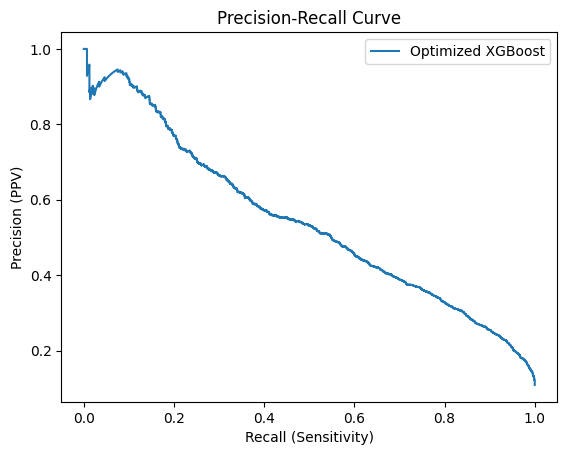

In [6]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs_opt)

plt.plot(recall, precision, label='Optimized XGBoost')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()